In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import PCA
from sklearn.metrics import (
  accuracy_score, 
  recall_score, 
  f1_score, 
  r2_score,
  precision_score, 
  classification_report, 
  confusion_matrix, 
  mean_squared_error, 
  mean_absolute_error,
)

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from typing import Literal


Options = Literal['mean', 'std']


cpus = os.cpu_count()
cmap_skyblue = plt.get_cmap('Blues')

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/45/data.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [3]:
df['num'].unique()  # target

array([0, 2, 1, 3, 4], dtype=int64)

In [4]:
df.rename(columns={'num': 'target'}, inplace=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


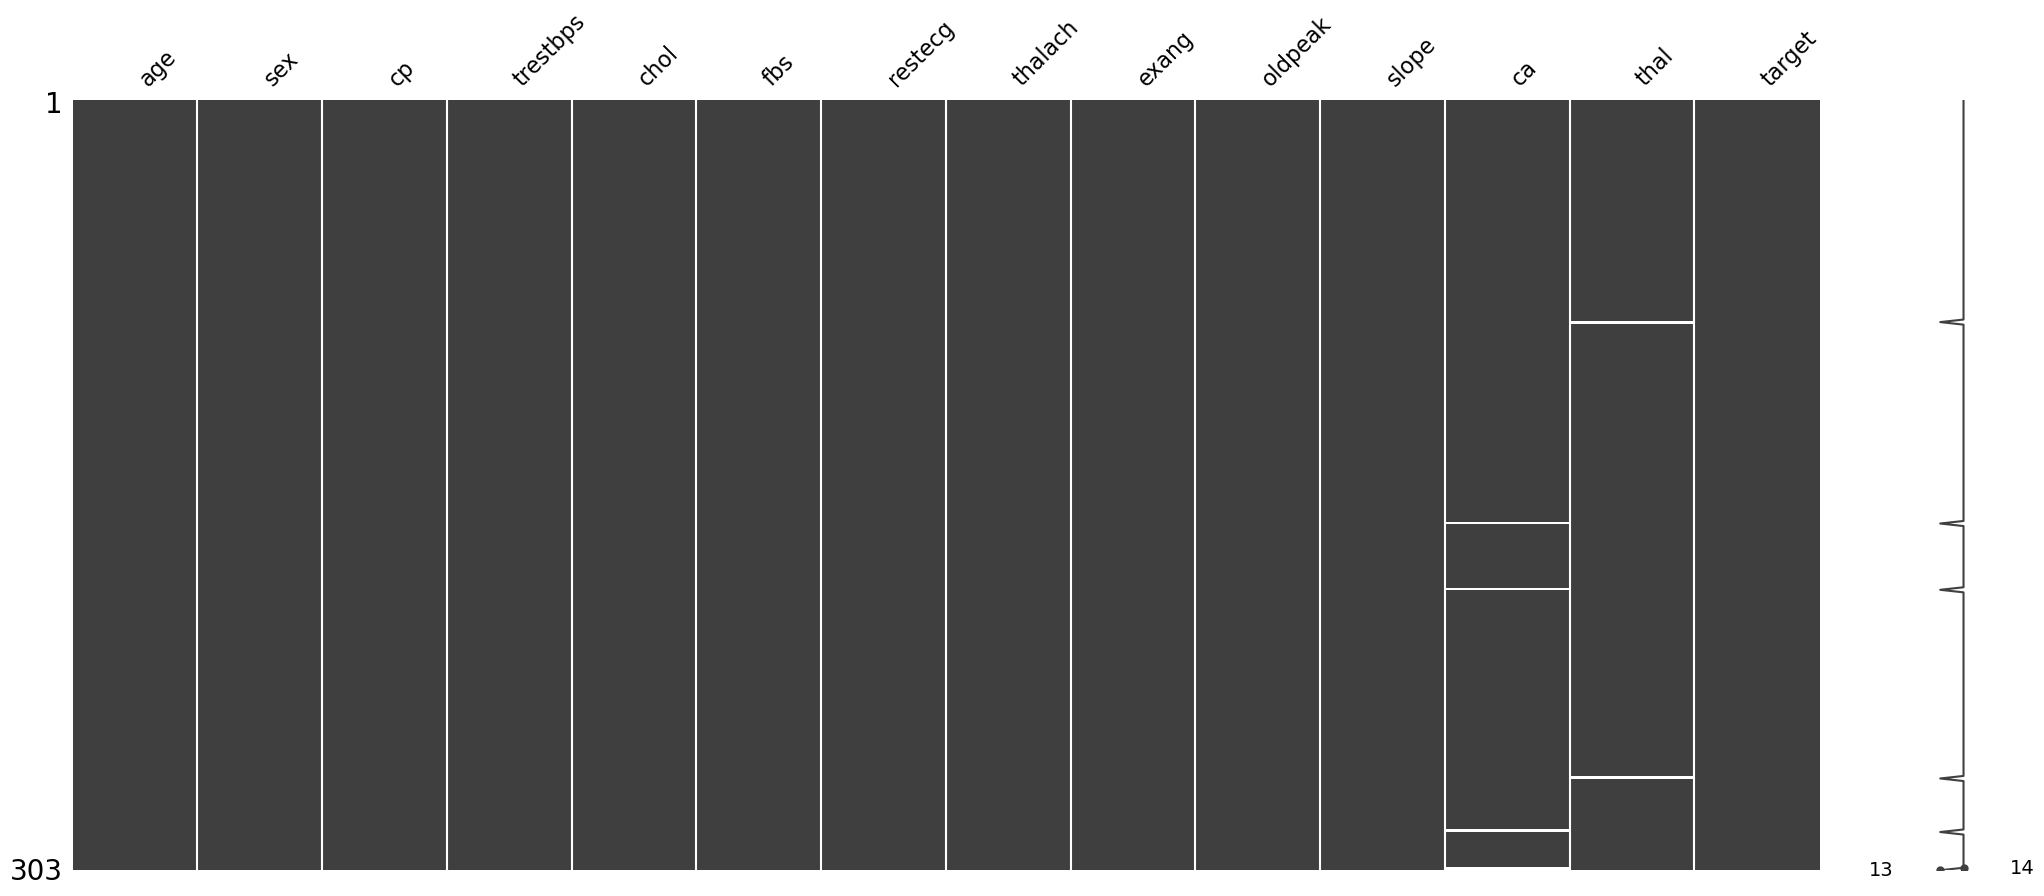

In [5]:
msno.matrix(df)
plt.show()

In [6]:
def auto_set_or_drop(df: pd.DataFrame, percent: float = 0.5, option: Options | None = 'std'):
  calc = df.isnull().sum() / df.sum()
  test = calc > percent
  data = test.to_dict()

  for key, upper in data.items():
    if upper:

      # drop it, too much nan!
      df.drop(key, axis=1, inplace=True)
      continue

    # make it noisy!
    df_col = df[key]

    if option == 'mean':
      df_col.fillna(df_col.mean(), inplace=True)

    elif option == 'std':
      df_col.fillna(df_col.std(), inplace=True)

    else:
      df.dropna(inplace=True)

  # drop constant values
  df.drop(df.columns[df.nunique() == 1], axis=1, inplace=True)
    
  # drop duplicates
  df.drop_duplicates(inplace=True)


auto_set_or_drop(df, percent=0.5, option='std')

In [7]:
df[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


In [8]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

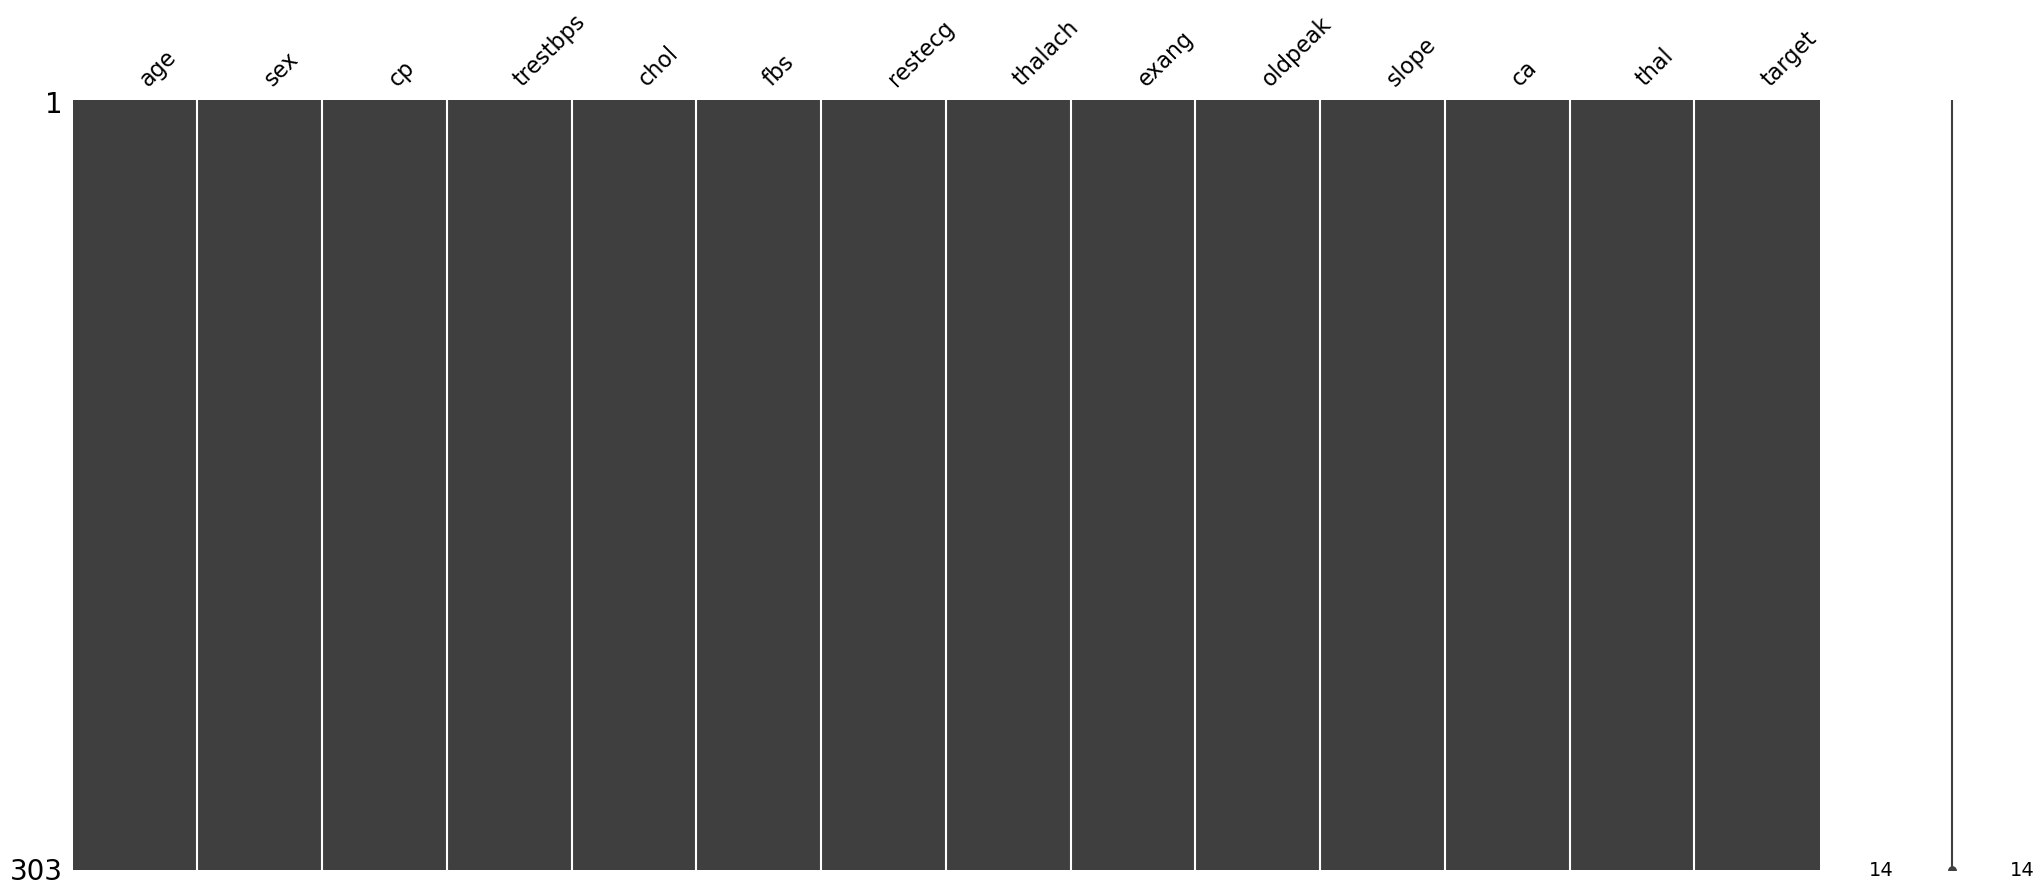

In [9]:
msno.matrix(df)
plt.show()

In [10]:
column_name_target = 'target'
x = df.drop(column_name_target, axis=1).values  # columns selain 'target' + normalization
y = df[column_name_target].values  # cuman 'target'

## Make it Data More Balance!

In [11]:
# oversampling
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

# setup
x_smote, y_smote = smote.fit_resample(x, y)
x_adasyn, y_adasyn = adasyn.fit_resample(x, y)

# undersampling
nearmiss = NearMiss(n_neighbors=3)

# setup
x_nearmiss, y_nearmiss = nearmiss.fit_resample(x, y)

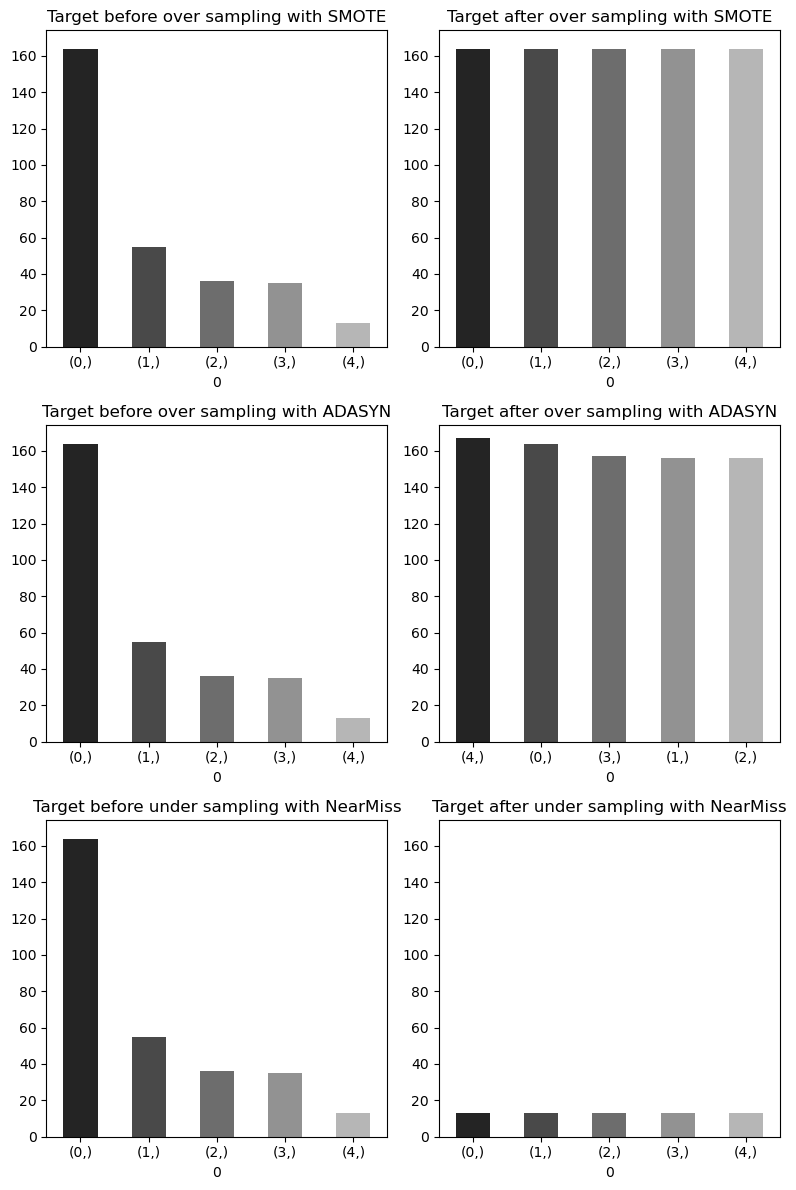

In [12]:
# SMOTE & ADASYN & NearMiss

df_y = pd.DataFrame(data=y)
df_y_max = df_y.value_counts().max() + 10

fig, ax = plt.subplots(3, 2)

plt.subplot(3, 2, 1)
df_y_view = df_y.value_counts()
df_y_axes = df_y_view.plot(kind='bar', figsize=(8, 12), color=sns.palettes.mpl_palette('gray'))
df_y_axes.set_ylim([0, df_y_max])
plt.title('Target before over sampling with SMOTE')
plt.xticks(rotation=0)

plt.subplot(3, 2, 2)
df_y_smote = pd.DataFrame(data=y_smote)
df_y_smote_view = df_y_smote.value_counts()
df_y_smote_axes = df_y_smote_view.plot(kind='bar', figsize=(8, 12), color=sns.palettes.mpl_palette('gray'))
df_y_smote_axes.set_ylim([0, df_y_max])
plt.title('Target after over sampling with SMOTE')
plt.xticks(rotation=0)

plt.subplot(3, 2, 3)
df_y_view = df_y.value_counts()
df_y_axes = df_y_view.plot(kind='bar', figsize=(8, 12), color=sns.palettes.mpl_palette('gray'))
df_y_axes.set_ylim([0, df_y_max])
plt.title('Target before over sampling with ADASYN')
plt.xticks(rotation=0)

plt.subplot(3, 2, 4)
df_y_adasyn = pd.DataFrame(data=y_adasyn)

df_y_adasyn_view = df_y_adasyn.value_counts()
df_y_adasyn_axes = df_y_adasyn_view.plot(kind='bar', figsize=(8, 12), color=sns.palettes.mpl_palette('gray'))
df_y_adasyn_axes.set_ylim([0, df_y_max])
plt.title('Target after over sampling with ADASYN')
plt.xticks(rotation=0)

plt.subplot(3, 2, 5)
df_y_view = df_y.value_counts()
df_y_axes = df_y_view.plot(kind='bar', figsize=(8, 12), color=sns.palettes.mpl_palette('gray'))
df_y_axes.set_ylim([0, df_y_max])
plt.title('Target before under sampling with NearMiss')
plt.xticks(rotation=0)

plt.subplot(3, 2, 6)
df_y_nearmiss = pd.DataFrame(data=y_nearmiss)

df_y_nearmiss_view = df_y_nearmiss.value_counts()
df_y_nearmiss_axes = df_y_nearmiss_view.plot(kind='bar', figsize=(8, 12), color=sns.palettes.mpl_palette('gray'))
df_y_nearmiss_axes.set_ylim([0, df_y_max])
plt.title('Target after under sampling with NearMiss')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [13]:
# origin
scaler_norm = MinMaxScaler()
x_norm = scaler_norm.fit_transform(x)

# over-sampling
scaler_smote_norm = MinMaxScaler()
x_smote_norm = scaler_smote_norm.fit_transform(x_smote)

scaler_adasyn_norm = MinMaxScaler()
x_adasyn_norm = scaler_adasyn_norm.fit_transform(x_adasyn)

# under-sampling
scaler_nearmiss_norm = MinMaxScaler()
x_nearmiss_norm = scaler_nearmiss_norm.fit_transform(x_nearmiss)

In [14]:
# origin
scaler_std = StandardScaler()
x_std = scaler_std.fit_transform(x)

# over-sampling
scaler_smote_std = StandardScaler()
x_smote_std = scaler_smote_std.fit_transform(x_smote)

scaler_adasyn_std = StandardScaler()
x_adasyn_std = scaler_adasyn_std.fit_transform(x_adasyn)

# under-sampling
scaler_nearmiss_std = StandardScaler()
x_nearmiss_std = scaler_nearmiss_std.fit_transform(x_nearmiss)

In [51]:
# origin
pca = PCA(n_components=2, random_state=0)
x_pca = pca.fit_transform(x)

pca_norm = PCA(n_components=2, random_state=0)
x_pca_norm = pca_norm.fit_transform(x_norm)

pca_std = PCA(n_components=2, random_state=0)
x_pca_std = pca_std.fit_transform(x_std)

# over-sampling
pca_smote = PCA(n_components=2, random_state=0)
x_smote_pca = pca_smote.fit_transform(x_smote)

pca_smote_norm = PCA(n_components=2, random_state=0)
x_smote_pca_norm = pca_smote_norm.fit_transform(x_smote_norm)

pca_smote_std = PCA(n_components=2, random_state=0)
x_smote_pca_std = pca_smote_std.fit_transform(x_smote_std)

pca_adasyn = PCA(n_components=2, random_state=0)
x_adasyn_pca = pca_adasyn.fit_transform(x_adasyn)

pca_adasyn_norm = PCA(n_components=2, random_state=0)
x_adasyn_pca_norm = pca_adasyn_norm.fit_transform(x_adasyn_norm)

pca_adasyn_std = PCA(n_components=2, random_state=0)
x_adasyn_pca_std = pca_adasyn_std.fit_transform(x_adasyn_std)

# under-sampling
pca_nearmiss = PCA(n_components=2, random_state=0)
x_nearmiss_pca = pca_nearmiss.fit_transform(x_nearmiss)

pca_nearmiss_norm = PCA(n_components=2, random_state=0)
x_nearmiss_pca_norm = pca_nearmiss_norm.fit_transform(x_nearmiss_norm)

pca_nearmiss_std = PCA(n_components=2, random_state=0)
x_nearmiss_pca_std = pca_nearmiss_std.fit_transform(x_nearmiss_std)


 Explained Variance Ratio: [0.74649486 0.15007471]

 Singular Value: [901.4360951  404.18043328]


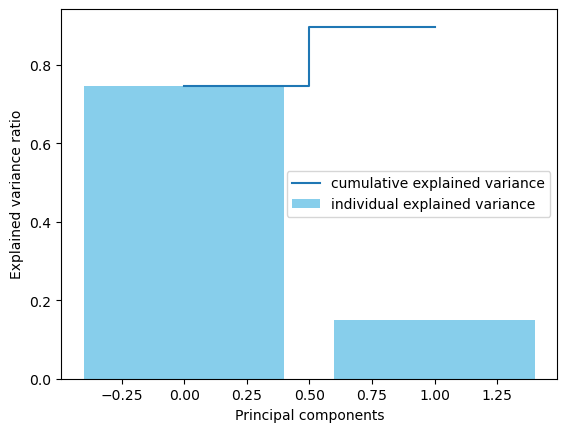

Cumulative explained ratio: [0.74649486 0.89656957]


In [52]:
var_ratio = pca.explained_variance_ratio_
print("\n Explained Variance Ratio:",var_ratio)

sv = pca.singular_values_
print("\n Singular Value:",sv)

cum_var_ratio = np.cumsum(var_ratio)

# plt.figure(figsize=(10, 5))
plt.bar(range(len(var_ratio)),
        var_ratio,
        # alpha=0.3333,
        align='center',
        label='individual explained variance',
        color = '#87CEEB')
plt.step(range(len(cum_var_ratio)),
         cum_var_ratio,
         where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

print("Cumulative explained ratio:", cum_var_ratio)

In [53]:
# n_components = np.array(range(len(var_ratio)))[var_ratio < 0.1][0]
# n_components

In [54]:
choices = [

  # origin family
  ('x', (x, y), []),
  ('x_pca', (x_pca, y), [pca]),
  ('x_pca_norm', (x_pca_norm, y), [scaler_norm, pca_norm]),
  ('x_pca_std', (x_pca_std, y), [scaler_std, pca_std]),
  ('x_norm', (x_norm, y), [scaler_norm]),
  ('x_std', (x_std, y), [scaler_std]),

  # smote family
  ('x_smote', (x_smote, y_smote), [smote]),
  ('x_smote_pca', (x_smote_pca, y_smote), [smote, pca_smote]),
  ('x_smote_pca_norm', (x_smote_pca_norm, y_smote), [smote, scaler_smote_norm, pca_smote_norm]),
  ('x_smote_pca_std', (x_smote_pca_std, y_smote), [smote, scaler_smote_std, pca_smote_std]),
  ('x_smote_norm', (x_smote_norm, y_smote), [smote, scaler_smote_norm]),
  ('x_smote_std', (x_smote_std, y_smote), [smote, scaler_smote_std]),

  # adasyn family
  ('x_adasyn', (x_adasyn, y_adasyn), [adasyn]),
  ('x_adasyn_pca', (x_adasyn_pca, y_adasyn), [adasyn, pca_adasyn]),
  ('x_adasyn_pca_norm', (x_adasyn_pca_norm, y_adasyn), [adasyn, scaler_adasyn_norm, pca_adasyn_norm]),
  ('x_adasyn_pca_std', (x_adasyn_pca_std, y_adasyn), [adasyn, scaler_adasyn_std, pca_adasyn_std]),
  ('x_adasyn_norm', (x_adasyn_norm, y_adasyn), [adasyn, scaler_adasyn_norm]),
  ('x_adasyn_std', (x_adasyn_std, y_adasyn), [adasyn, scaler_adasyn_std]),

  # nearmiss family
  ('x_nearmiss', (x_nearmiss, y_nearmiss), [nearmiss]),
  ('x_nearmiss_pca', (x_nearmiss_pca, y_nearmiss), [nearmiss, pca_nearmiss]),
  ('x_nearmiss_pca_norm', (x_nearmiss_pca_norm, y_nearmiss), [nearmiss, scaler_nearmiss_norm, pca_nearmiss_norm]),
  ('x_nearmiss_pca_std', (x_nearmiss_pca_std, y_nearmiss), [nearmiss, scaler_nearmiss_std, pca_nearmiss_std]),
  ('x_nearmiss_norm', (x_nearmiss_norm, y_nearmiss), [nearmiss, scaler_nearmiss_norm]),
  ('x_nearmiss_std', (x_nearmiss_std, y_nearmiss), [nearmiss, scaler_nearmiss_std]),
]

1 1 x_pca
1 2 x_pca_norm
1 3 x_pca_std
1 4 x_smote_pca
2 1 x_smote_pca_norm
2 2 x_smote_pca_std
2 3 x_adasyn_pca
2 4 x_adasyn_pca_norm
3 1 x_adasyn_pca_std
3 2 x_nearmiss_pca
3 3 x_nearmiss_pca_norm
3 4 x_nearmiss_pca_std


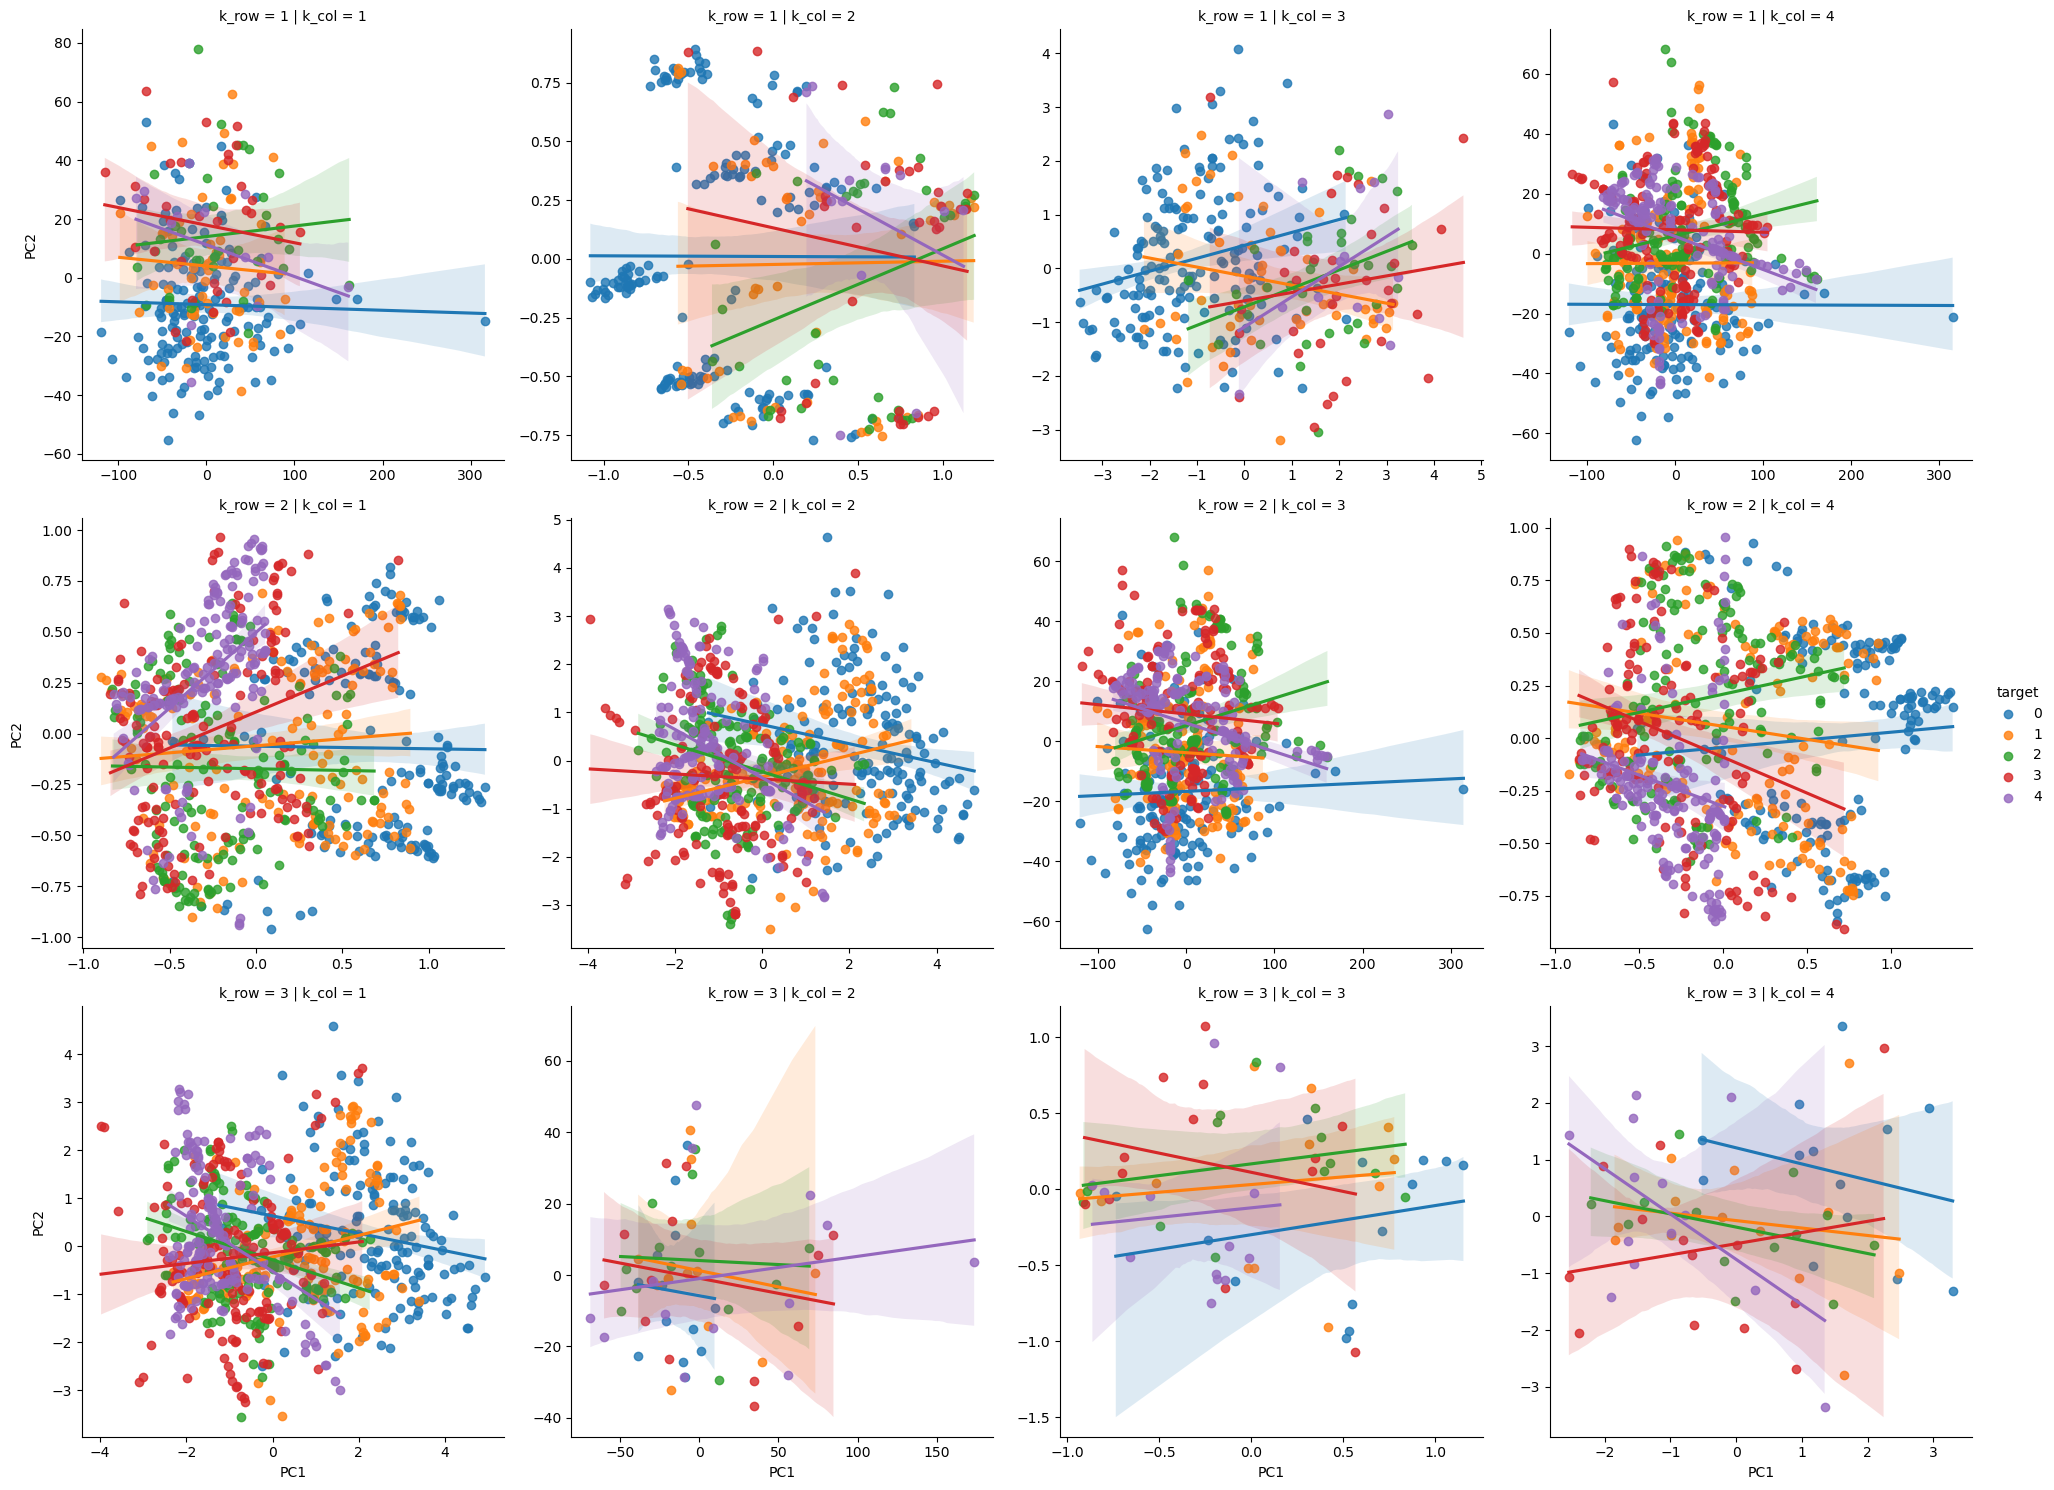

In [55]:
import math

from typing import Tuple


x_pca_data_all = [(choice_name, *choice_xy) for (choice_name, choice_xy, _) in choices if 'pca' in choice_name]

x_pca_data_all_count = len(x_pca_data_all)
k = math.sqrt(x_pca_data_all_count)
rows, cols = math.floor(k), math.ceil(k)
# fig, ax = plt.subplots(rows, cols, figsize=(rows * 8, cols * 8))

def find_pos_by_idx(idx: int, rows: int, cols: int) -> Tuple[int, int]:
  z_idx = idx + 1
  k_row = 0
  k_col = 0
  
  for row in range(rows):
    stopped = 0
    x_row = row + 1
    s_row = row * cols
    
    for col in range(cols):
      x_col = col + 1
      y_idx = s_row + x_col
      
      if z_idx >= y_idx:
        k_row = x_row
        k_col = x_col
        continue
        
      stopped = 1
      break
    
    if stopped == 1:
      break
  
  return k_row, k_col


pca_df_mul = []
for idx, (x_pca_name, x_pca_data, y_data) in enumerate(x_pca_data_all):
  k_row, k_col = find_pos_by_idx(idx, rows, cols)
  print(k_row, k_col, x_pca_name)
  
  pca_df = pd.DataFrame(data=x_pca_data, columns=['PC1', 'PC2'])
  pca_df['name'] = x_pca_name
  pca_df['target'] = y_data
  pca_df['k_row'] = k_row
  pca_df['k_col'] = k_col
  
  pca_df_mul.append(pca_df)

pca_df = pd.concat(pca_df_mul)
# plt.figure(layout='constrained')
sns.lmplot(data=pca_df, x='PC1', y='PC2', row='k_row', col='k_col', hue='target', facet_kws=dict(sharex=False, sharey=False))
# sns.lmplot(data=pca_df, x='PC1', y='PC2', row='k_row', col='k_col', hue='target', fit_reg=False, legend=True, height=4, facet_kws=dict(sharex=False, sharey=False))
plt.show()

In [18]:
import math

from typing import Sequence, Mapping


def minmax(v, v_min=0.0, v_max=1.0, p_nan=True, p_none=True):
  if p_none:
    if v is None:
      return 0.0
  
  if p_nan:
    if math.isnan(v):
      return 0.0
  
  return min(max(v, v_min), v_max)


EvaluationMode = Literal['f1', 'r2']
def evaluation(y_test, y_pred, mode: EvaluationMode = 'f1'):

  if mode == 'f1':
    return dict(
        accuracy=minmax(accuracy_score(y_test, y_pred, normalize=True)),
        recall=minmax(recall_score(y_test, y_pred, average='weighted', zero_division=0)),
        precision=minmax(precision_score(y_test, y_pred, average='weighted', zero_division=0)),
        f1_score=minmax(f1_score(y_test, y_pred, average='weighted', zero_division=0)),
    )
  
  if mode == 'r2':
    return dict(
        mse=minmax(mean_squared_error(y_test, y_pred)),
        mae=minmax(mean_absolute_error(y_test, y_pred)),
        r2_score=minmax(r2_score(y_test, y_pred)),
    )
    
  return dict()


def pprint(data, start = '', end = '\r\n', output = False, tab = '\t'):
  if isinstance(data, Mapping):
    temp = '|' + end
    
    for k, v in data.items():
      temp += start + k + ' = ' + pprint(v, tab + start, end, output=True) + end
    
    if not output:
      print(temp)
      
    return temp

  if not isinstance(data, str):
    if isinstance(data, Sequence):
      temp = '|' + end
      
      for k, v in enumerate(data):
        temp += start + str(k) + ' = ' + pprint(v, tab + start, end, output=True) + end
      
      if not output:
        print(temp)
        
      return temp

  if not output:
    print(data)
    
  return str(data)

In [19]:
from sklearn.model_selection import KFold
from pandas.core.series import Series
from sklearn.base import is_regressor


def train_models(models, choices = [], test_size=0.1, random_state=42, n_splits=1):
  results = []
  
  for model_idx, (model_name, model_cb) in enumerate(models):
    print(model_name, '#' + str(model_idx))

    model = model_cb()
    regression = is_regressor(model)

    model_results = []
    for choice_idx, (choice_name, (x, y), preprocessing) in enumerate(choices):
      print('--', choice_name, '#' + str(choice_idx))

      # splitting data training 80%, and testing 20%
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

      # KFold from 80% of x_train from train_test_split

      # using kfold instead of train_test_split
      model = model_cb()
      kfold_scores = np.zeros(shape=(n_splits,), dtype=np.float64)
      
      # using kfold must be n_splits greater than or equal of 2 
      if n_splits > 1:
        kf = KFold(n_splits)
        
        for kf_idx, (train_index, test_index) in enumerate(kf.split(x_train)):
          kf_x_train, kf_x_test = None, None
          kf_y_train, kf_y_test = None, None
          
          if isinstance(x_train, Series):
            kf_x_train, kf_x_test = x_train.iloc[train_index], x_train.iloc[test_index]
          
          elif isinstance(x_train, np.ndarray):
            kf_x_train, kf_x_test = x_train[train_index], x_train[test_index]
            
          else:
            raise Exception('type data x is not valid')
          
          if isinstance(y_train, Series):
            kf_y_train, kf_y_test = y_train.iloc[train_index], y_train.iloc[test_index]
          
          elif isinstance(y_train, np.ndarray):
            kf_y_train, kf_y_test = y_train[train_index], y_train[test_index]
            
          else:
            raise Exception('type data y is not valid')
        
          model.fit(kf_x_train, kf_y_train)
          y_pred = model.predict(kf_x_test)
          
          scores = evaluation(kf_y_test, y_pred, mode='f1' if not regression else 'r2')
          score = scores.get('f1_score' if not regression else 'r2_score')
          if score is None:
            score = scores.get('f1_score') or scores.get('r2_score')
            
          score = minmax(score)
          
          kfold_scores[kf_idx] = score
          print('KFold', '#' + str(kf_idx), 'score=' + str(score))
          
      elif n_splits == 1:
        model.fit(x_train, y_train)
        
      else:
        raise Exception('n_splits must be greater than 0')

      # final evaluation
      kfold_score = np.mean(kfold_scores)

      # testing model, prediction
      y_pred = model.predict(x_test)

      #* FIX y_pred not same a y_test (indexes)

      # make it same as type y_pred and y_test
      y_pred = y_pred.round().astype(y_test.dtype)

      # evaluation
      scores = evaluation(y_test, y_pred, mode='f1' if not regression else 'r2')
      pprint(scores, tab='  ')

      # append data results
      model_results.append(dict(
          model=model,
          name=choice_name,
          y_pred=y_pred, y_test=y_test,  # matrix confusion (required)
          preprocessing=preprocessing,
          kfold_score=kfold_score,
          scores=scores,
      ))

      print('--')
    print()

    results.append(dict(
        name=model_name,
        results=model_results,
    ))

  return results

In [20]:
import math


def get_comparison_from_results(results):
  comparison_values = []

  for result_idx, result in enumerate(results):
    model = result.get('model')
    model_name = result.get('name')
    model_results = result.get('results')
    print(model_name, '#' + str(result_idx))
    
    regression = is_regressor(model)

    for choice_idx, choice in enumerate(model_results):
      choice_name = choice.get('name')
      scores = choice.get('scores')
      name = model_name + '_' + choice_name

      print('--', name, '#' + str(choice_idx))
      score = scores.get('f1_score' if not regression else 'r2_score')
      if score is None:
        score = scores.get('f1_score') or scores.get('r2_score')
        
      score = minmax(score)

      comparison_values.append((name, score))
    
    print(end='\r\n\r\n')

  comparison = pd.DataFrame(comparison_values, columns=['Model', 'Accuracy'])
  comparison = comparison.sort_values(by='Accuracy', ascending=False)
  comparison.head()

  return comparison

In [21]:
import math
import secrets
import string


def gen_short_name(chars: int = 8):
  return "".join(secrets.choice(string.digits + string.ascii_letters) for _ in range(chars))


def secret_names(names, uniques = []):
  unique_names = []
  
  for _ in range(len(names)):
    name = gen_short_name()
    
    while True:  
      if name in uniques:
        name = gen_short_name()
        continue
      
      break
    
    unique_names.append(name)
  return unique_names


def plot_comparison(comparison: pd.DataFrame, k: int = 12):
  
  n = comparison.values.shape[0]
  p = n / k  
  v = math.sqrt(p)
  
  rows, cols = math.floor(v), math.ceil(v)
  idx = 0
  
  #* FIX p great than rows and cols
  if rows * cols < p:
    rows = cols

  fig, ax = plt.subplots(rows, cols, figsize=(cols * 10, rows * 12))
  uniques = []
  refs = []

  for i in range(0, n, k):
    names = comparison['Model'].values[i:i+k]
    scores = comparison['Accuracy'].values[i:i+k]
    
    unique_names = secret_names(names, uniques)

    ref = dict(zip(unique_names, names))
    refs.append(ref)
    pprint(link_names, tab='  ')

    plt.subplot(rows, cols, idx + 1)
    bars = plt.bar(unique_names, scores, color=sns.palettes.mpl_palette('Dark2'))
    idx += 1

    # static y-score
    plt.ylim([0, 1])
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.title('Evaluation')
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
  
  return refs

KNeighborsClassifier #0
-- x #0
|
accuracy = 0.4918032786885246
recall = 0.4918032786885246
precision = 0.3276545590913961
f1_score = 0.3915690866510539

--
-- x_pca #1
|
accuracy = 0.4918032786885246
recall = 0.4918032786885246
precision = 0.443564701778863
f1_score = 0.4333398386677076

--
-- x_pca_norm #2
|
accuracy = 0.5081967213114754
recall = 0.5081967213114754
precision = 0.4695028871042676
f1_score = 0.482112261632003

--
-- x_pca_std #3
|
accuracy = 0.47540983606557374
recall = 0.47540983606557374
precision = 0.49361137897782065
f1_score = 0.47208402432283025

--
-- x_norm #4
|
accuracy = 0.5081967213114754
recall = 0.5081967213114754
precision = 0.43579234972677594
f1_score = 0.46586807072402453

--
-- x_std #5
|
accuracy = 0.4918032786885246
recall = 0.4918032786885246
precision = 0.47751294219154444
f1_score = 0.48087431693989074

--
-- x_smote #6
|
accuracy = 0.6890243902439024
recall = 0.6890243902439024
precision = 0.6860824865829165
f1_score = 0.6819492049936747

--
-- 

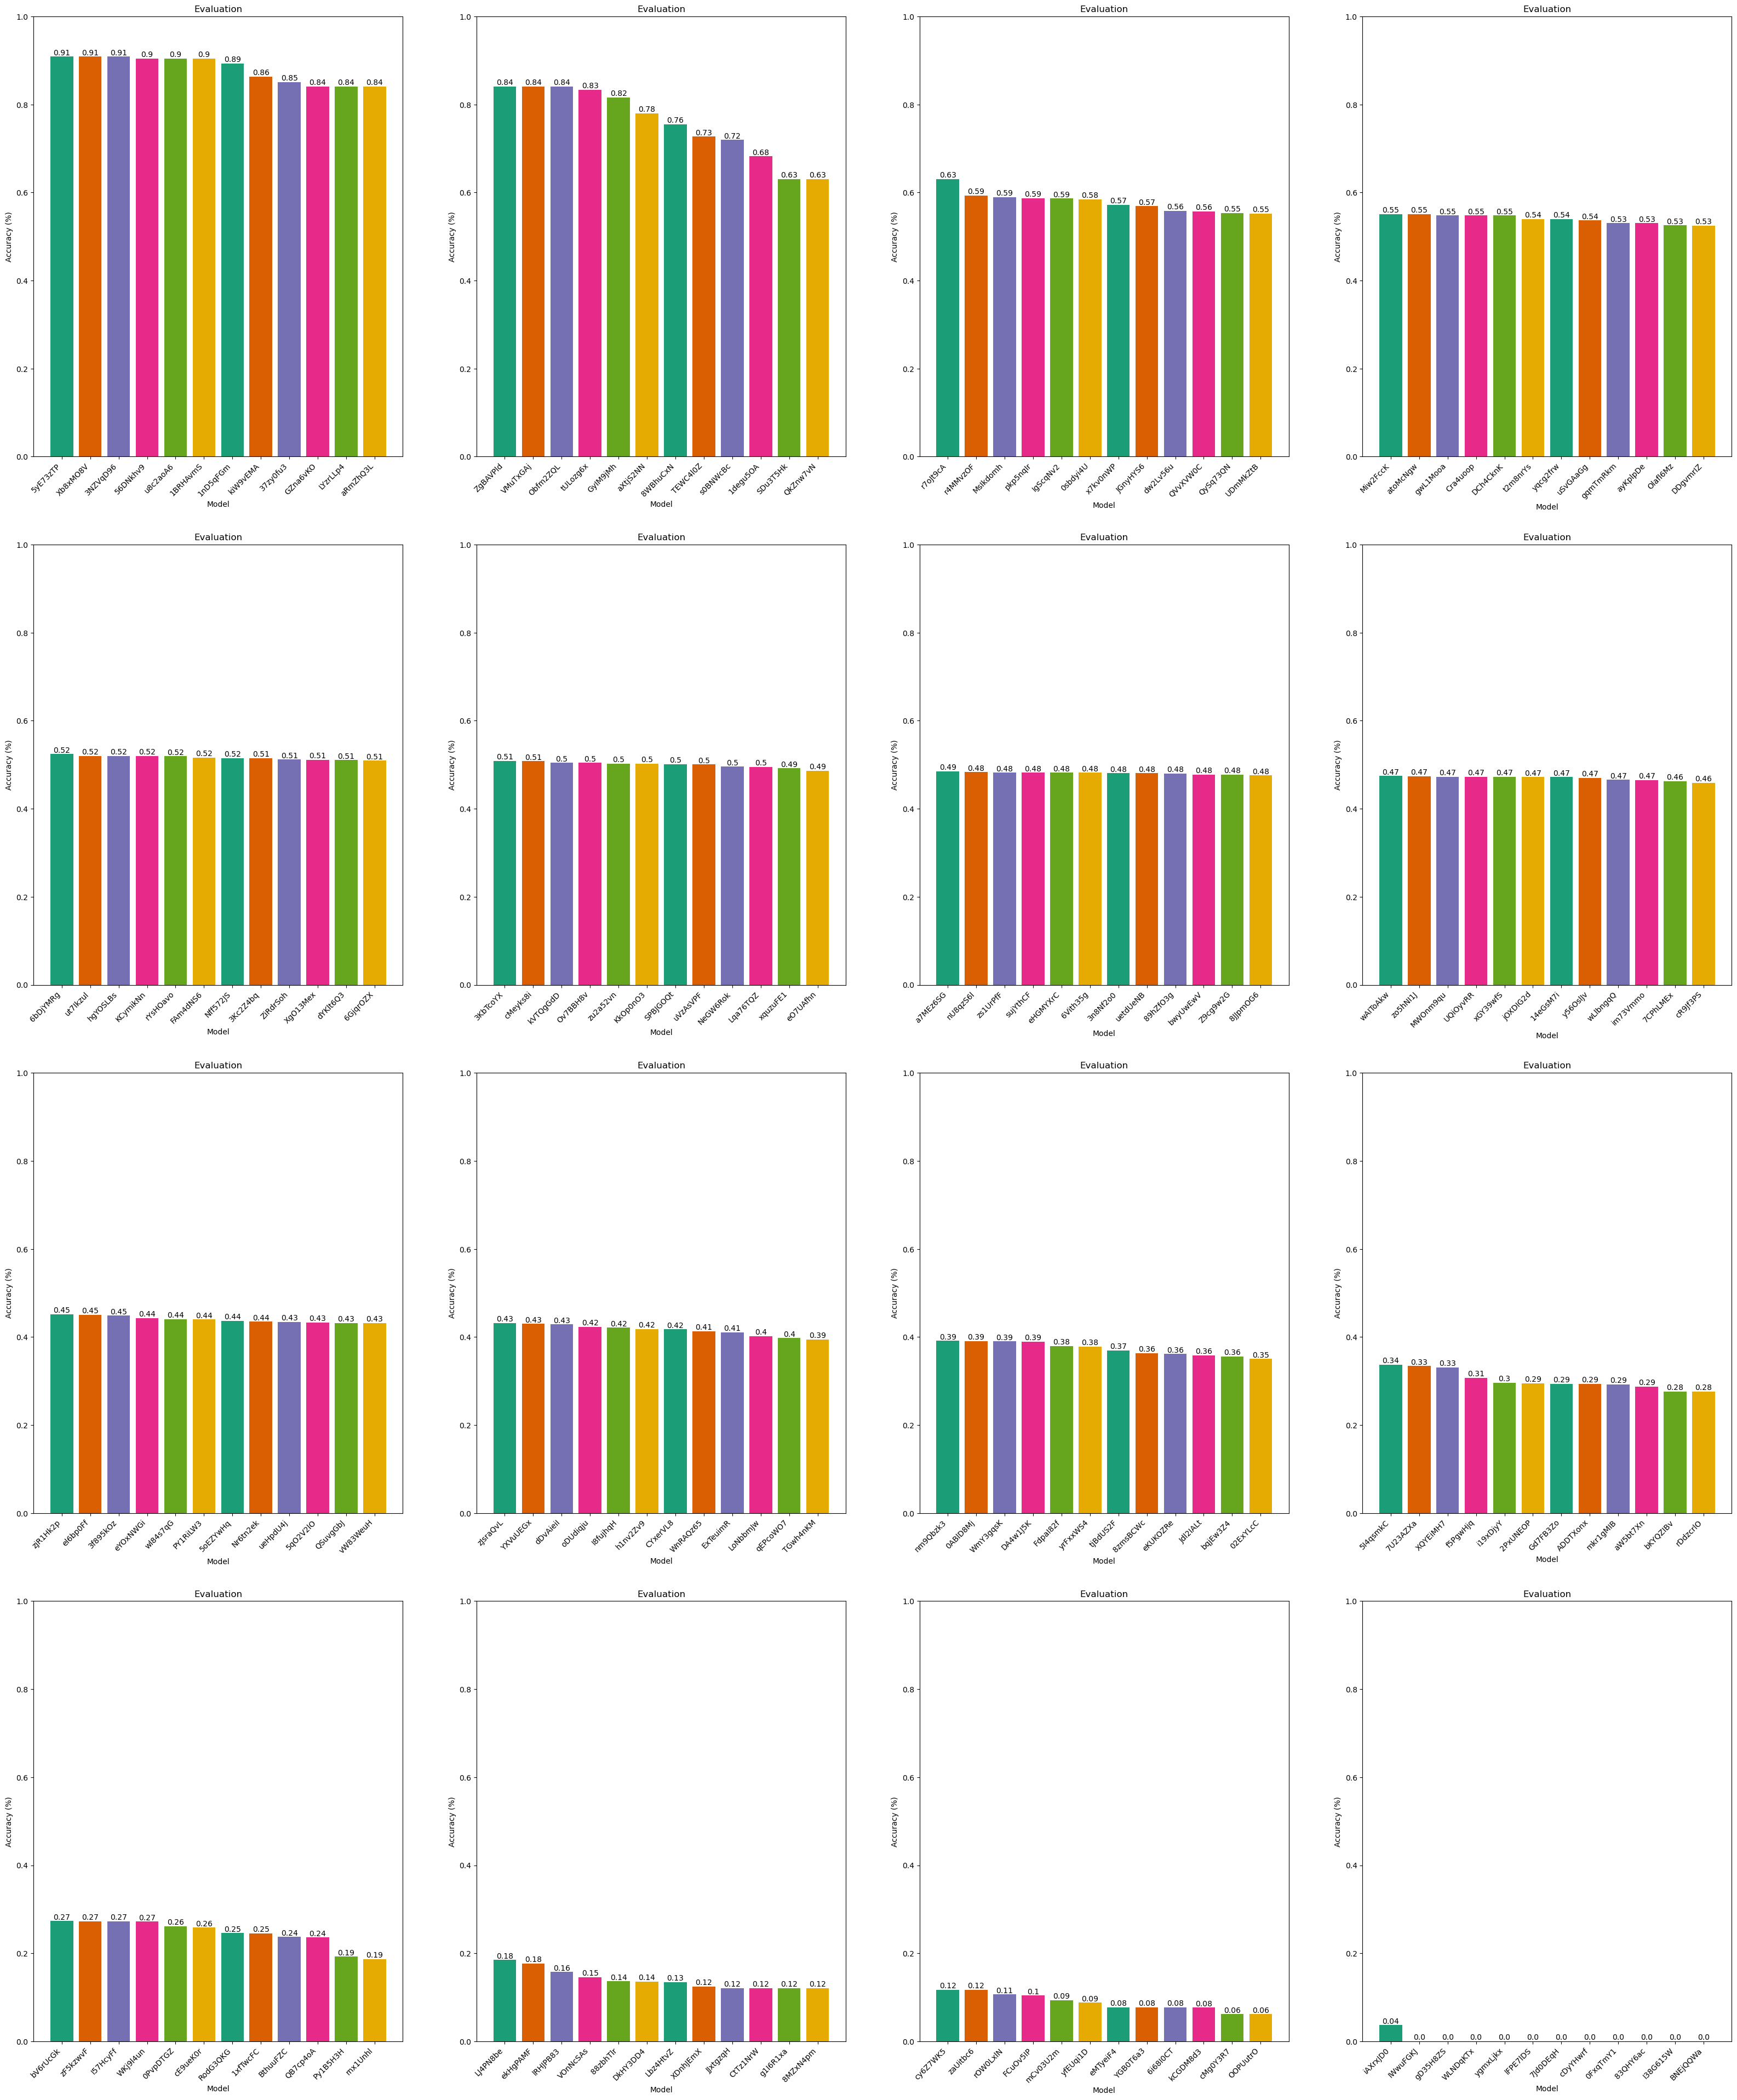

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier
from sklearn.svm import SVC

grid_cv_models = [
  ('RandomForestClassifier', lambda : GridSearchCV(RandomForestClassifier(), dict(
      n_estimators=[10, 50, 100, 200],
      max_depth=[3, 5, 10],
      criterion=['gini', 'entropy'],
    ), 
    scoring="accuracy",
    cv=5,
  )),
  
  ('LinearRegression', lambda : GridSearchCV(LinearRegression(), dict(
      fit_intercept= [True],
      copy_X= [True],
      positive= [True],
    ),
    scoring="r2",
    cv=5,
  )),
  
  ('LogisticRegression', lambda : GridSearchCV(LogisticRegression(), dict(
      solver=['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
      C=np.logspace(-3, 3, 7),
    ),
    scoring="r2",
    cv=5,
  )),
  
  ('DecisionTreeClassifier', lambda : GridSearchCV(DecisionTreeClassifier(), dict(
      max_depth=[3, 5, 10],
      criterion=['gini', 'entropy'],
      splitter=['best', 'random'],
    ),
    scoring="accuracy",
    cv=5,
  )),
  
  ('DecisionTreeRegressor', lambda : GridSearchCV(DecisionTreeRegressor(), dict(
      max_depth=[3, 5, 10],
      criterion=['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
      splitter=['best', 'random'],
    ),
    scoring="r2",
    cv=5,
  )),
  
  ('KNeighborsClassifier', lambda : GridSearchCV(KNeighborsClassifier(), dict(
      n_neighbors=[3, 5, 7, 9],
      weights=['uniform', 'distance'],
      metric=['euclidean', 'manhattan', 'minkowski'],
    ),
    scoring="accuracy",
    cv=5,
  )),
  
  ('XGBClassifier', lambda : GridSearchCV(XGBClassifier(), dict(
      n_estimators=[10, 50, 100, 200], 
      max_depth=[3, 5, 10],
      learning_rate=[0.01, 0.1, 0.2, 0.3],
    ),
    scoring="accuracy",
    cv=5,
  )),
]

models = [
  ('KNeighborsClassifier', lambda : KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='minkowski')),
  ('RandomForestClassifier', lambda : RandomForestClassifier(n_estimators=100, random_state=42)),
  ('LinearRegression', lambda : LinearRegression(fit_intercept=True, copy_X=False, positive=False)),
  ('LogisticRegression', lambda : LogisticRegression(solver='liblinear')),
  ('DecisionTreeClassifier', lambda : DecisionTreeClassifier(max_depth=5, criterion='gini', splitter='best')),
  ('DecisionTreeRegressor', lambda : DecisionTreeRegressor(max_depth=5, criterion='squared_error', splitter='best')),
  ('XGBClassifier', lambda : XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=42)),
  ('SVC', lambda : SVC()),
]

results = train_models(models, choices, test_size=0.2, n_splits=1)
comparison = get_comparison_from_results(results)
links = plot_comparison(comparison)
plt.show()

In [57]:
rank_values = [(idx + 1, name.split('_')[0], comparison['Accuracy'].values[idx]) for idx, name in enumerate(comparison['Model'].unique())]
rank = pd.DataFrame(rank_values, columns=['Rank', 'Model', 'Accuracy'])
rank.drop_duplicates(subset='Model', inplace=True)
rank

,Rank,Model,Accuracy
0,1,RandomForestClassifier,0.908558
6,7,KNeighborsClassifier,0.893403
8,9,SVC,0.851107
9,10,XGBClassifier,0.841137
22,23,DecisionTreeClassifier,0.630292
25,26,LogisticRegression,0.592927
41,42,DecisionTreeRegressor,0.539359
46,47,LinearRegression,0.525579


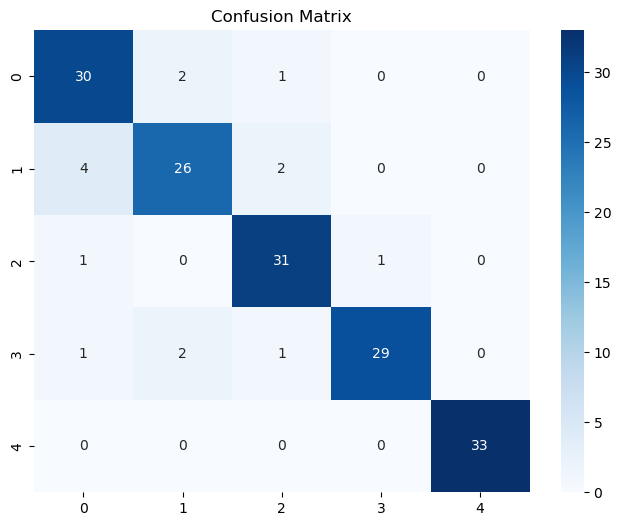

In [64]:
def best_model_from_results(results):
  max_score = 0.0
  model_selected = None
  choice_selected = None

  for model_idx, model in enumerate(results):
    model_results = model.get('results')
    
    for choice_idx, choice in enumerate(model_results):
      scores = choice.get('scores')
      model_fit = choice.get('model')
      regression = is_regressor(model_fit)
      score = scores.get('f1_score' if not regression else 'r2_score')
      if score is None:
        score = scores.get('f1_score') or scores.get('r2_score')
        
      score = minmax(score)
      
      if max_score < score:
        max_score = score
        model_selected = model
        choice_selected = choice
  
  if model_selected is None or choice_selected is None:
    raise Exception('couldn\'t get best model from results')
    
  best_model_data = dict(
    name=model_selected.get('name') + '_' + choice_selected.get('name'),
    model=choice_selected.get('model'),
    use_smote=choice_selected.get('name').startswith('x_smote'),
    use_adasyn=choice_selected.get('name').startswith('x_adasyn'),
    use_nearmiss=choice_selected.get('name').startswith('x_nearmiss'),
    preprocessing=choice_selected.get('preprocessing'),
    scores=choice_selected.get('scores'),
  )
    
  return best_model_data, model_selected, choice_selected, max_score


best_model_data, model_selected, choice_selected, max_score = best_model_from_results(results)


if model_selected is not None:
  if choice_selected is not None:
    name = model_selected.get('name')
    choice_name = choice_selected.get('name')
    
    scores = choice_selected.get('scores')
    y_pred = choice_selected.get('y_pred')
    y_test = choice_selected.get('y_test')
    
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_skyblue)
    plt.title('Confusion Matrix')
    plt.show()
  

In [65]:
pprint(best_model_data, tab='  ')

|
name = RandomForestClassifier_x_smote
model = RandomForestClassifier(random_state=42)
use_smote = True
use_adasyn = False
use_nearmiss = False
preprocessing = |
  0 = SMOTE(random_state=42)

scores = |
  accuracy = 0.9085365853658537
  recall = 0.9085365853658537
  precision = 0.9107433217189315
  f1_score = 0.908558228819527




'|\r\nname = RandomForestClassifier_x_smote\r\nmodel = RandomForestClassifier(random_state=42)\r\nuse_smote = True\r\nuse_adasyn = False\r\nuse_nearmiss = False\r\npreprocessing = |\r\n  0 = SMOTE(random_state=42)\r\n\r\nscores = |\r\n  accuracy = 0.9085365853658537\r\n  recall = 0.9085365853658537\r\n  precision = 0.9107433217189315\r\n  f1_score = 0.908558228819527\r\n\r\n'

In [61]:
import joblib


with open('best_data_model.jbl', 'wb') as stream:
  joblib.dump(best_model_data, stream)